# 0. Imports

### 0.1 Libs

In [2]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


### 0.2 Helper Functions

### 0.3 Loading data

* Fonte: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

In [3]:
# Credentials to access SQL Database:

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

# Connection with database:

conn = pg.connect(user = username,
                password = pwd,
                host = host,
                port = port,
                database = database)

# Query

query = """
    SELECT
        i.id,
        i.previously_insured,
        i.annual_premium,
        i.vintage,
        i.response,
        u.gender,
        u.age,
        u.region_code,
        u.policy_sales_channel,
        v.driving_license,
        v.vehicle_age,
        v.vehicle_damage
    FROM 
        pa004.users u
        JOIN pa004.vehicle v ON (u.id = v.id)
        JOIN pa004.insurance i ON (u.id = i.id)
"""

df_train_raw = pd.read_sql(query, conn)
conn.close()


/home/vitor/.pyenv/versions/3.9.0/envs/CrossSell/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# 1. Data Description

### 1.0 Overview

In [4]:
df1 = df_train_raw.copy()

df1

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381070,1,38254.0,127,0,Male,24,8.0,152.0,1,< 1 Year,No
381105,381079,0,39740.0,170,0,Female,58,28.0,26.0,1,1-2 Year,Yes
381106,381082,1,51619.0,80,0,Female,75,28.0,26.0,1,1-2 Year,No
381107,381097,0,34541.0,44,0,Female,49,10.0,26.0,1,1-2 Year,Yes


### 1.1 Data Dimensions

In [6]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:381109
Number of Columns:12


### 1.2 Data Types

In [7]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

### 1.3 Check NA

In [8]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

### 1.4 Change Types

In [9]:
df1['previously_insured'] = df1['previously_insured'].apply(lambda x: 'yes' if x==1 else 'no')
df1['driving_license'] = df1['driving_license'].apply(lambda x: 'yes' if x==1 else 'no')
df1['response'] = df1['response'].apply(lambda x: 'yes' if x==1 else 'no')

df1.dtypes

id                        int64
previously_insured       object
annual_premium          float64
vintage                   int64
response                 object
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license          object
vehicle_age              object
vehicle_damage           object
dtype: object

### 1.5 Estatística Descritiva

##### 1.5.0 Defining Datasets

In [10]:
num_attributes = df1[['annual_premium', 'vintage', 'age']]
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

##### 1.5.1 Numerical Atributes

In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
1,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688
2,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655


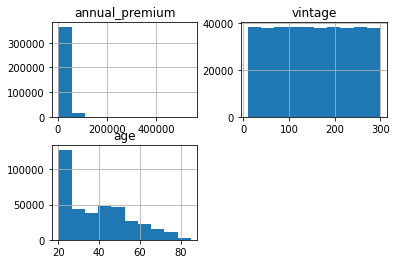

In [12]:
num_attributes.hist();

##### 1.5.1 Categorical Atributes

<AxesSubplot:xlabel='response', ylabel='id'>

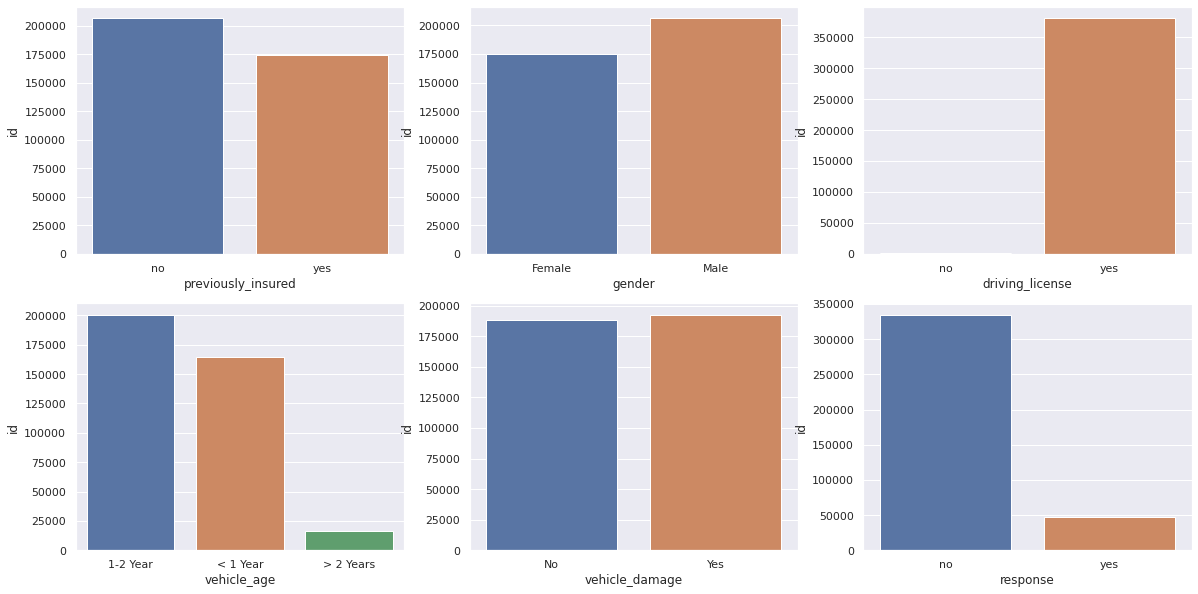

In [13]:
sns.set(rc={'figure.figsize':(20,10)})

plt.subplot(2,3,1)
aux1 = df1[['id', 'previously_insured']].groupby(['previously_insured']).count().reset_index()
sns.barplot(x='previously_insured', y='id', data=aux1)

plt.subplot(2,3,2)
aux1 = df1[['id', 'gender']].groupby(['gender']).count().reset_index()
sns.barplot(x='gender', y='id', data=aux1)

plt.subplot(2,3,3)
aux1 = df1[['id', 'driving_license']].groupby(['driving_license']).count().reset_index()
sns.barplot(x='driving_license', y='id', data=aux1)

plt.subplot(2,3,4)
aux1 = df1[['id', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(x='vehicle_age', y='id', data=aux1)

plt.subplot(2,3,5)
aux1 = df1[['id', 'vehicle_damage']].groupby(['vehicle_damage']).count().reset_index()
sns.barplot(x='vehicle_damage', y='id', data=aux1)

plt.subplot(2,3,6)
aux1 = df1[['id', 'response']].groupby(['response']).count().reset_index()
sns.barplot(x='response', y='id', data=aux1)

# 2. Feature Engineering